In [25]:
import re
import os
import inspect
import warnings
from IPython.display import display
from copy import deepcopy

import pandas as pd
from path import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.simplefilter('ignore')

In [2]:
CURRENT_DIR = Path(inspect.getsourcefile(lambda: 0)).abspath().parent
results_paths = [path for path in CURRENT_DIR.files() if path.ext == '.csv']
results_paths.sort()
results_paths

[Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-1-img_EdgeDetection-5x5-16x16.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-1-img_EdgeDetection-5x5-32x32.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-1-img_EdgeDetection-9x9-16x16.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-1-img_EdgeDetection-9x9-32x32.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-2-img_EdgeDetection-5x5-16x16.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-2-img_EdgeDetection-5x5-32x32.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-2-img_EdgeDetection-9x9-16x16.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-2-img_EdgeDetection-9x9-32x32.csv'),
 Path('/home/lore/CLionProjects/CUDA_kernel_image_processing/results/res-3-img_EdgeDetection-5x5-16x16.csv'),
 Path('/ho

In [3]:
# number of iterations executed for each image size, [ 100x100, FHD, 4K, 8K ]
# !for filename in *.csv; do wc -l $filename | awk '{print $1}'; done

In [3]:
# col_names = ['seq', 'par_nt', 'seq_par_nt', 'par', 'seq_par', 'tiling_nt', 'seq_tiling_nt', 'tiling', 'seq_tiling', 'tiling_constant_nt', 'seq_tiling_constant_nt', 'tiling_constant', 'seq_tiling_constant', 'counter']
col_names = [
    'CPU',
    'GPU (NO TRANSFER)', 'SPEEDUP [CPU / GPU (NO TRANSFER)]',
    'GPU', 'SPEEDUP [CPU / GPU]',
    'GPU (TILING, NO TRANSFER)', 'SPEEDUP [CPU / GPU (TILING, NO TRANSFER)]',
    'GPU (TILING)', 'SPEEDUP [CPU / GPU (TILING)]',
    'GPU (TILING + CONST, NO TRANSFER)', 'SPEEDUP [CPU / GPU (TILING + CONST, NO TRANSFER)]',
    'GPU (TILING + CONST)', 'SPEEDUP [CPU / GPU (TILING + CONST)]',
    'identifier'
]

In [4]:
from typing import Tuple
def take_identifier(path: str) -> Tuple[str, str, str]:
    img_id = str(path.basename())[4]
    mask_width = str(path.basename())[24:27]
    tile_width = str(path.basename())[28:33]
    return (img_id, mask_width, tile_width)

In [5]:
results = pd.DataFrame(columns=col_names)
for path in results_paths:
    results = results.append(pd.read_csv(path, names=col_names, header=None), ignore_index=True)
    identifier = '_'.join(take_identifier(path))
    results['identifier'] = results['identifier'].fillna(identifier)

In [6]:
id_dict = {k: v for v, k in enumerate(results.identifier.unique())}
id_dict_rev = {v: k for k, v in id_dict.items()}

results['id_mapped'] = [id_dict[x] for x in results.identifier]
grouped_mean = results.groupby('id_mapped').mean().round(2)
grouped_mean.index = [id_dict_rev[x] for x in grouped_mean.index]
df_mean = deepcopy(grouped_mean)

In [7]:
speedup_columns = grouped_mean.columns.map(lambda x: x.startswith('SPEEDUP'))
grouped_mean.loc[:, speedup_columns] = grouped_mean.loc[:, speedup_columns].apply(
    lambda col: col.apply(
        lambda x: str(round(x, 1)) + 'X'
    )
)

In [8]:
grouped_std = results.groupby('id_mapped').std().round(2)
grouped_std.index = [id_dict_rev[x] for x in grouped_std.index]

In [9]:
big_table = deepcopy(grouped_mean)
n_rows, n_cols = grouped_mean.shape
for i in range(n_rows):
    for j in range(n_cols):
        big_table.iloc[i, j] = str(grouped_mean.iloc[i, j]) + ' pm ' + str(grouped_std.iloc[i, j])
        if 'X' not in big_table.iloc[i, j]:
            big_table.iloc[i, j] += ' [ms]'

In [10]:
indexes_no_transfer = [0, 1, 2, 5, 6, 9, 10]
indexes_with_transfer = [0, 3, 4, 7, 8, 11, 12]

table_5_16_NT = big_table.iloc[[(i * 4) + 0 for i in range(4)], indexes_no_transfer].T
table_5_16_WT = big_table.iloc[[(i * 4) + 0 for i in range(4)], indexes_with_transfer].T
table_5_32_NT = big_table.iloc[[(i * 4) + 1 for i in range(4)], indexes_no_transfer].T
table_5_32_WT = big_table.iloc[[(i * 4) + 1 for i in range(4)], indexes_with_transfer].T
table_9_16_NT = big_table.iloc[[(i * 4) + 2 for i in range(4)], indexes_no_transfer].T
table_9_16_WT = big_table.iloc[[(i * 4) + 2 for i in range(4)], indexes_with_transfer].T
table_9_32_NT = big_table.iloc[[(i * 4) + 3 for i in range(4)], indexes_no_transfer].T
table_9_32_WT = big_table.iloc[[(i * 4) + 3 for i in range(4)], indexes_with_transfer].T

In [11]:
table_5_16_NT.to_latex('./tables/NO_TRANSFER_5X5_16X16.tex')
table_5_16_WT.to_latex('./tables/WITH_TRANSFER_5X5_16X16.tex')
table_5_32_NT.to_latex('./tables/NO_TRANSFER_5X5_32X32.tex')
table_5_32_WT.to_latex('./tables/WITH_TRANSFER_5X5_32X32.tex')
table_9_16_NT.to_latex('./tables/NO_TRANSFER_9X9_16X16.tex')
table_9_16_WT.to_latex('./tables/WITH_TRANSFER_9X9_16X16.tex')
table_9_32_NT.to_latex('./tables/NO_TRANSFER_9X9_32X32.tex')
table_9_32_WT.to_latex('./tables/WITH_TRANSFER_9X9_32X32.tex')

## PLOTS

In [12]:
df_mean

CPU  GPU (NO TRANSFER)  SPEEDUP [CPU / GPU (NO TRANSFER)]  \
1_5x5_16x16      3.55               0.07                              49.91   
1_5x5_32x32      3.62               0.09                              41.48   
1_9x9_16x16      9.46               0.17                              54.74   
1_9x9_32x32     10.24               0.21                              47.65   
2_5x5_16x16    531.22               7.90                              67.35   
2_5x5_32x32    518.93               8.16                              63.62   
2_9x9_16x16   1632.71              26.00                              62.79   
2_9x9_32x32   1606.73              25.27                              63.58   
3_5x5_16x16   2143.25              29.15                              73.71   
3_5x5_32x32   2165.39              31.16                              76.09   
3_9x9_16x16   6535.23              94.90                              68.97   
3_9x9_32x32   6528.78              92.82                              70.48   
4_5x5_16x16  10275.15             123.10                              83.57   
4_5x5_32x32  10165.94             120.45                              84.57   
4_9x9_16x16  28117.31             380.49                              73.92   
4_9x9_32x32  28202.99             368.25                              76.59   

                GPU  SPEEDUP [CPU / GPU]  GPU (TILING, NO TRANSFER)  \
1_5x5_16x16   66.38                 0.05                       2.66   
1_5x5_32x32   71.12                 0.05                       0.03   
1_9x9_16x16   65.32                 0.14                       0.07   
1_9x9_32x32   66.03                 0.15                       0.07   
2_5x5_16x16   83.99                 6.33                       2.20   
2_5x5_32x32   83.48                 6.23                       2.22   
2_9x9_16x16  106.17                15.41                       8.40   
2_9x9_32x32  106.37                15.17                       5.51   
3_5x5_16x16  150.83                14.22                       7.92   
3_5x5_32x32  146.84                14.11                      16.66   
3_9x9_16x16  217.79                30.04                      29.16   
3_9x9_32x32  214.94                30.41                      18.88   
4_5x5_16x16  411.82                24.97                      30.74   
4_5x5_32x32  407.95                24.94                      29.13   
4_9x9_16x16  668.56                42.07                     126.03   
4_9x9_32x32  655.07                43.06                      78.90   

             SPEEDUP [CPU / GPU (TILING, NO TRANSFER)]  GPU (TILING)  \
1_5x5_16x16                                     106.08          0.84   
1_5x5_32x32                                     108.17          0.52   
1_9x9_16x16                                     126.02          1.02   
1_9x9_32x32                                     153.61          0.34   
2_5x5_16x16                                     241.45         11.53   
2_5x5_32x32                                     233.65         11.60   
2_9x9_16x16                                     194.36         17.94   
2_9x9_32x32                                     291.53         14.88   
3_5x5_16x16                                     270.78         64.56   
3_5x5_32x32                                     270.29         63.43   
3_9x9_16x16                                     224.65         85.93   
3_9x9_32x32                                     346.54         76.46   
4_5x5_16x16                                     334.43        247.16   
4_5x5_32x32                                     349.13        245.54   
4_9x9_16x16                                     223.34        344.22   
4_9x9_32x32                                     357.90        295.70   

             SPEEDUP [CPU / GPU (TILING)]  GPU (TILING + CONST, NO TRANSFER)  \
1_5x5_16x16                         11.05                               3.50   
1_5x5_32x32                         10.89                               2.04   
1

In [13]:
#speedup_columns = grouped_mean.columns.map(lambda x: x.startswith('SPEEDUP'))
# indexes_no_transfer = [0, 1, 2, 5, 6, 9, 10]
# indexes_with_transfer = [0, 3, 4, 7, 8, 11, 12]

table_5_16_NT = df_mean.iloc[[(i * 4) + 0 for i in range(4)], indexes_no_transfer]
table_5_16_WT = df_mean.iloc[[(i * 4) + 0 for i in range(4)], indexes_with_transfer]
table_5_32_NT = df_mean.iloc[[(i * 4) + 1 for i in range(4)], indexes_no_transfer]
table_5_32_WT = df_mean.iloc[[(i * 4) + 1 for i in range(4)], indexes_with_transfer]
table_9_16_NT = df_mean.iloc[[(i * 4) + 2 for i in range(4)], indexes_no_transfer]
table_9_16_WT = df_mean.iloc[[(i * 4) + 2 for i in range(4)], indexes_with_transfer]
table_9_32_NT = df_mean.iloc[[(i * 4) + 3 for i in range(4)], indexes_no_transfer]
table_9_32_WT = df_mean.iloc[[(i * 4) + 3 for i in range(4)], indexes_with_transfer]

speedup_columns = table_5_16_NT.columns.map(lambda x: x.startswith('SPEEDUP'))  # overwritten

In [14]:
# NO DATA TRANSFERS
table_5_16_NT.iloc[:, speedup_columns]
table_5_32_NT.iloc[:, speedup_columns]
table_9_16_NT.iloc[:, speedup_columns]
table_9_32_NT.iloc[:, speedup_columns]

SPEEDUP [CPU / GPU (NO TRANSFER)]  \
1_9x9_32x32                              47.65   
2_9x9_32x32                              63.58   
3_9x9_32x32                              70.48   
4_9x9_32x32                              76.59   

             SPEEDUP [CPU / GPU (TILING, NO TRANSFER)]  \
1_9x9_32x32                                     153.61   
2_9x9_32x32                                     291.53   
3_9x9_32x32                                     346.54   
4_9x9_32x32                                     357.90   

             SPEEDUP [CPU / GPU (TILING + CONST, NO TRANSFER)]  
1_9x9_32x32                                             130.32  
2_9x9_32x32                                             329.35  
3_9x9_32x32                                             398.26  
4_9x9_32x32                                             430.12

In [15]:
# WITH DATA TRANSFERS
table_5_16_WT.iloc[:, speedup_columns]
# table_5_32_WT.iloc[:, speedup_columns]
# table_9_16_WT.iloc[:, speedup_columns]
# table_9_32_WT.iloc[:, speedup_columns]

SPEEDUP [CPU / GPU]  SPEEDUP [CPU / GPU (TILING)]  \
1_5x5_16x16                 0.05                         11.05   
2_5x5_16x16                 6.33                         46.07   
3_5x5_16x16                14.22                         33.20   
4_5x5_16x16                24.97                         41.57   

             SPEEDUP [CPU / GPU (TILING + CONST)]  
1_5x5_16x16                                 12.58  
2_5x5_16x16                                 48.67  
3_5x5_16x16                                 34.43  
4_5x5_16x16                                 43.03

In [16]:
table = table_5_16_WT.iloc[:, speedup_columns]
display(table)

SPEEDUP [CPU / GPU]  SPEEDUP [CPU / GPU (TILING)]  \
1_5x5_16x16                 0.05                         11.05   
2_5x5_16x16                 6.33                         46.07   
3_5x5_16x16                14.22                         33.20   
4_5x5_16x16                24.97                         41.57   

             SPEEDUP [CPU / GPU (TILING + CONST)]  
1_5x5_16x16                                 12.58  
2_5x5_16x16                                 48.67  
3_5x5_16x16                                 34.43  
4_5x5_16x16                                 43.03

In [44]:
# table_dict = {
# '../report/figures/NO_TRANSFER_5X5_16X16.png': table_5_16_NT,
# '../report/figures/WITH_TRANSFER_5X5_16X16.png': table_5_16_WT,
# '../report/figures/NO_TRANSFER_5X5_32X32.png': table_5_32_NT,
# '../report/figures/WITH_TRANSFER_5X5_32X32.png': table_5_32_WT,
# '../report/figures/NO_TRANSFER_9X9_16X16.png': table_9_16_NT,
# '../report/figures/WITH_TRANSFER_9X9_16X16.png': table_9_16_WT,
# '../report/figures/NO_TRANSFER_9X9_32X32.png': table_9_32_NT,
# '../report/figures/WITH_TRANSFER_9X9_32X32.png': table_9_32_WT,
# }
table_dict = {
'../presentation/figures/NO_TRANSFER/5X5_16X16.png': table_5_16_NT,
'../presentation/figures/WITH_TRANSFER/5X5_16X16.png': table_5_16_WT,
'../presentation/figures/NO_TRANSFER/5X5_32X32.png': table_5_32_NT,
'../presentation/figures/WITH_TRANSFER/5X5_32X32.png': table_5_32_WT,
'../presentation/figures/NO_TRANSFER/9X9_16X16.png': table_9_16_NT,
'../presentation/figures/WITH_TRANSFER/9X9_16X16.png': table_9_16_WT,
'../presentation/figures/NO_TRANSFER/9X9_32X32.png': table_9_32_NT,
'../presentation/figures/WITH_TRANSFER/9X9_32X32.png': table_9_32_WT,
}

../presentation/figures/NO_TRANSFER/5X5_16X16.png


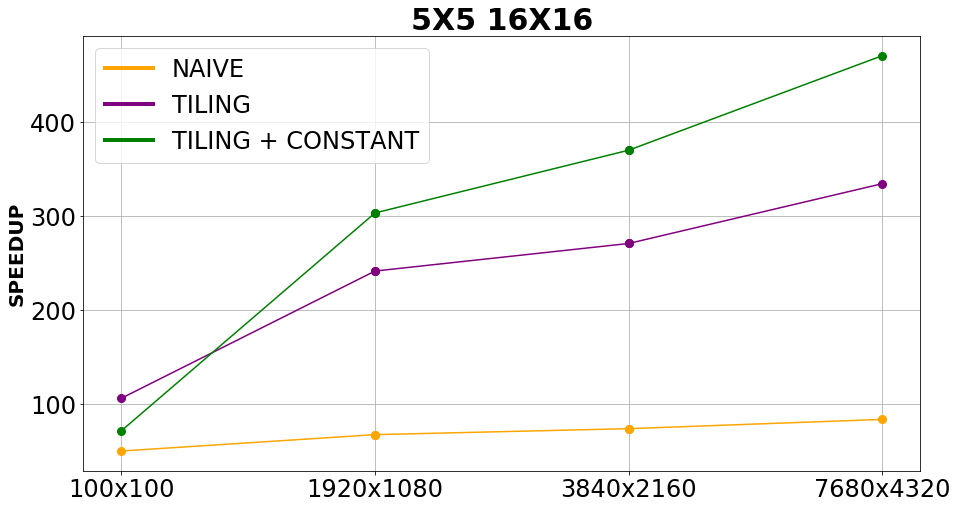

../presentation/figures/WITH_TRANSFER/5X5_16X16.png


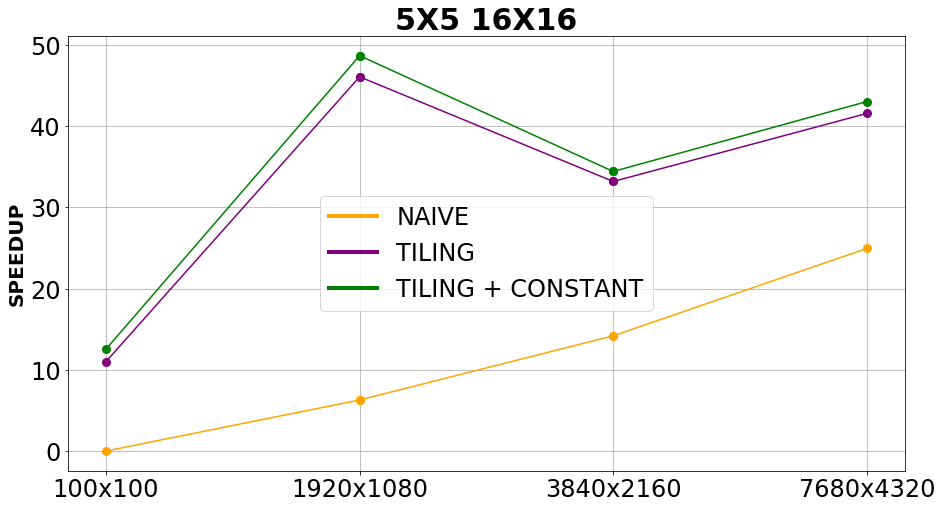

../presentation/figures/NO_TRANSFER/5X5_32X32.png


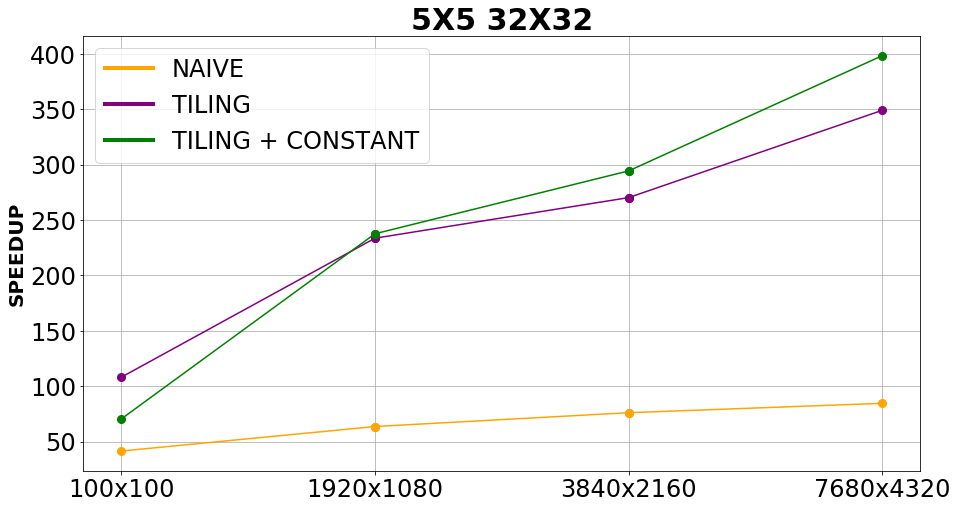

../presentation/figures/WITH_TRANSFER/5X5_32X32.png


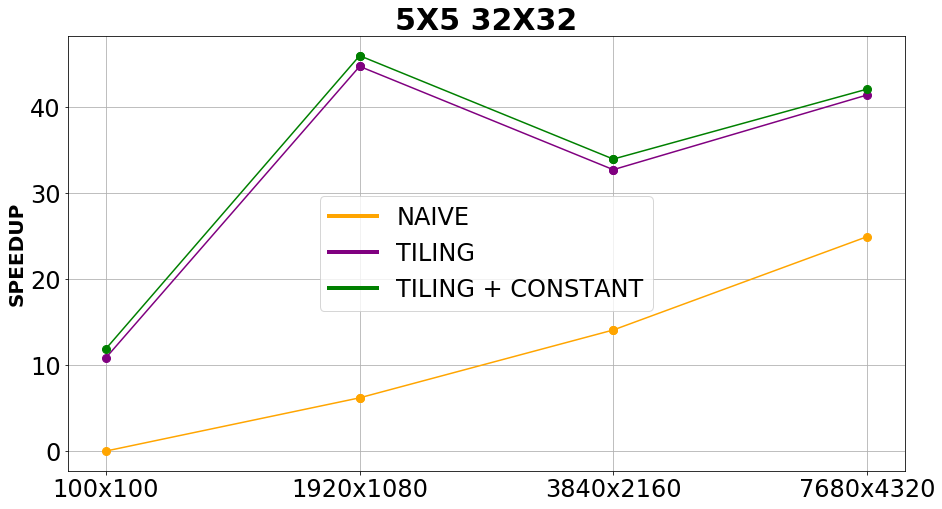

../presentation/figures/NO_TRANSFER/9X9_16X16.png


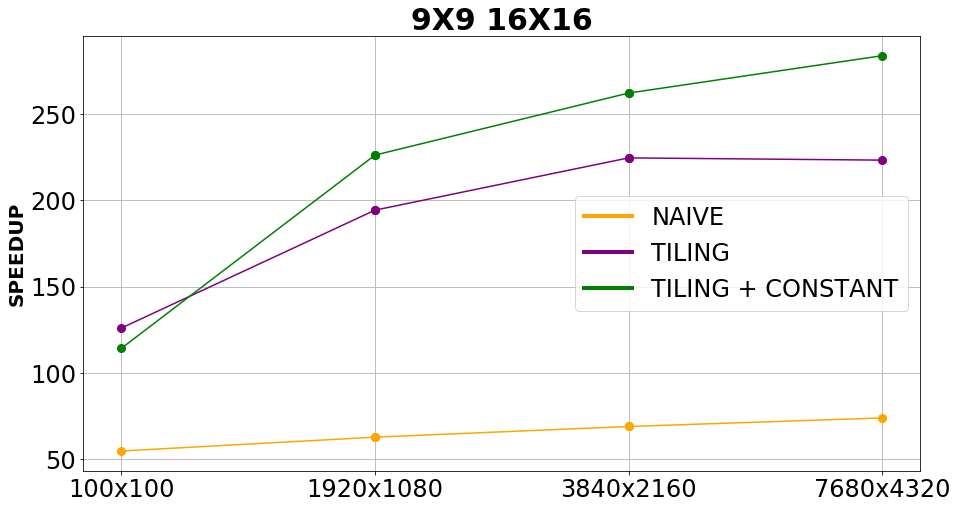

../presentation/figures/WITH_TRANSFER/9X9_16X16.png


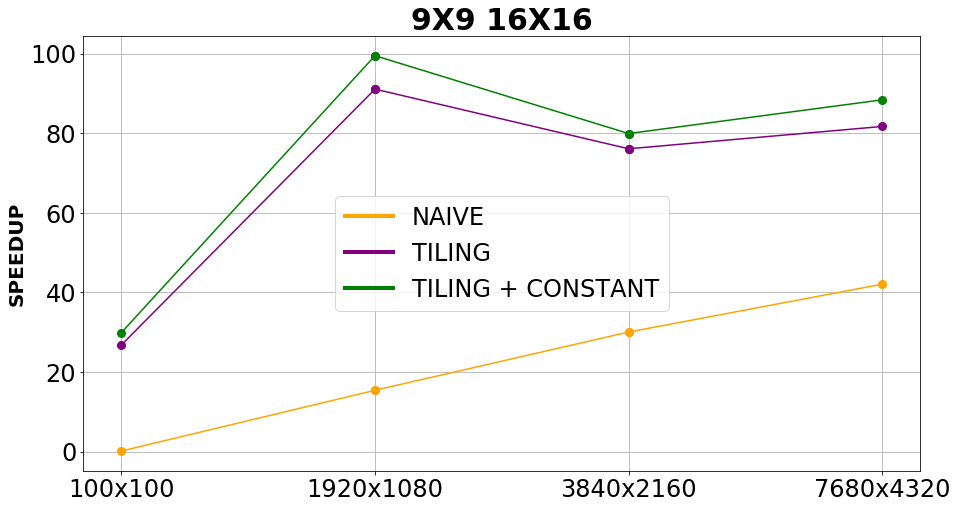

../presentation/figures/NO_TRANSFER/9X9_32X32.png


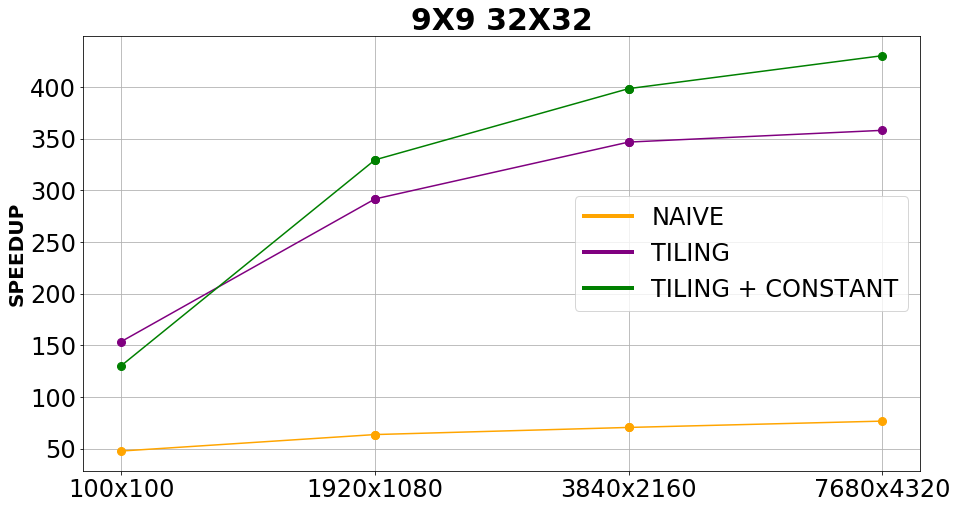

../presentation/figures/WITH_TRANSFER/9X9_32X32.png


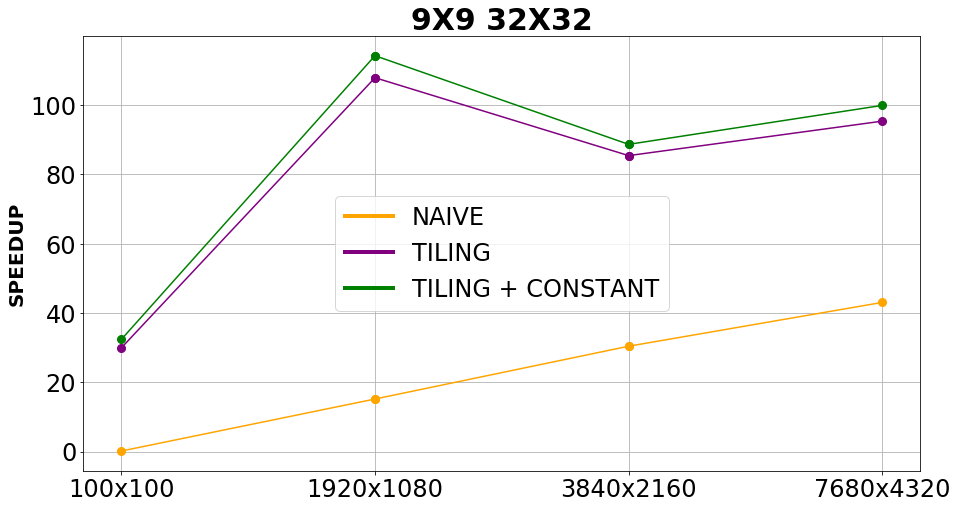

In [48]:
class Result:
    def __init__(self, values = None, color = 'red', name = ''):
        if values is not None:
            self.values = values
        self.color = color
        self.name = name

for path in table_dict:
    x = range(4)
    n = len(x)
    
    table = table_dict[path].iloc[:, speedup_columns]
    y1 = Result(table.iloc[:, 0], 'orange', 'NAIVE')
    y2 = Result(table.iloc[:, 1], 'purple', 'TILING')
    y3 = Result(table.iloc[:, 2], 'green', 'TILING + CONSTANT')
    all_y = [y1, y2, y3]

    fig, ax = plt.subplots(figsize=(15, 8))
    for i in range(n - 1):
        for y in all_y:
            plt.plot( x[i: i+2], y.values[i: i+2], 'o-', color=y.color, markersize=8 )

    plt.xticks(range(4), ('100x100', '1920x1080', '3840x2160', '7680x4320'))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    
    base = os.path.basename(path)
    ax.title.set_text(os.path.splitext(base)[0].replace('_', ' '))
    ax.title.set_fontsize(30)
    ax.title.set_fontweight('bold')


    ax.yaxis.label.set_text('SPEEDUP')
    ax.yaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontweight('bold')

    ax.grid(True)
    custom_lines = [ plt.Line2D([0], [0], color=y.color, lw=4) for y in all_y ]
    ax.legend(custom_lines, [y.name for y in all_y])
    plt.rc('legend',fontsize=24)
    
    plt.savefig(path, format='png')
    print(path)
    plt.show()